In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.4 MB/s eta 0:00:00


In [ ]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from ultralytics import YOLO
from PIL import Image
from pathlib import Path
import torch.nn.functional as F
import time
from tqdm.notebook import tqdm
import os
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

from google.colab.patches import cv2_imshow
#Flujo:
#Recibe imagen -- resize para segmentacion?
#Segmentación -- normalizar imagenet / resize modelo efficient
#Clasificación -- llamar modelo con la imagen resultante
#Arrojar clasificación y la probabilidad

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
RUTA_MODELO_SEG = '/content/drive/MyDrive/IA Avanzada/Dataset Lengua de Señas/best_seg.pt'
RUTA_MODELO_CLASIF = '/content/drive/MyDrive/IA Avanzada/Dataset Lengua de Señas/efficientNet_final_pro.pth' # El que guardaste
IMG_SIZE = 224
CONF_THRESHOLD_SEG = 0.5 # Umbral para segmentación antes 0.6

CLASS_NAMES = sorted([
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
    'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U',
    'V', 'W', 'X', 'Y', 'Z'
])
NUM_CLASSES = len(CLASS_NAMES)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Transformaciones de VALIDACIÓN (para inferencia)
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

try:
    model_seg = YOLO(RUTA_MODELO_SEG)
    model_seg.to(device)
    print("Modelo de Segmentación (YOLO) cargado exitosamente.")
except Exception as e:
    print(f"Error cargando modelo de segmentación: {e}")

try:
    #EfficientNet B0
    model_clasif = models.efficientnet_b0(weights=None) # No necesitamos pesos preentrenados aquí

    # Modificar la capa final
    in_features = model_clasif.classifier[1].in_features
    model_clasif.classifier[1] = nn.Linear(in_features, NUM_CLASSES)

    # Cargar pesos entrenados (.pth)
    model_clasif.load_state_dict(torch.load(RUTA_MODELO_CLASIF, map_location=device))
    model_clasif.to(device)

    #Modelo en modo de evaluación
    model_clasif.eval()
    print("Modelo de Clasificación (EfficientNet) cargado exitosamente.")

except Exception as e:
    print(f"Error cargando modelo de clasificación: {e}")

#Mapa de etiquetas
label_map_inverso = {idx: class_name for idx, class_name in enumerate(CLASS_NAMES)}

#Pipeline segmentación y clasificación

def clasificar_mano(ruta_imagen):
    try:
        #Cargar Imagen OpenCV
        img_original_bgr = cv2.imread(ruta_imagen)
        if img_original_bgr is None:
            return "Error", 0.0, "No se pudo leer la imagen."

        # Segmentación YOLO
        resultados_seg = model_seg.predict(img_original_bgr, conf=CONF_THRESHOLD_SEG, verbose=False)

        if resultados_seg[0].masks is None:
            return "N/A", 0.0, "No se detectó ninguna mano."

        #Preprocesamiento
        # Encontrar la máscara con el área más grande
        mascara_principal = max(resultados_seg[0].masks, key=lambda m: cv2.contourArea(m.xy[0]))

        # Crear la máscara binaria del tamaño original
        mascara_binaria = np.zeros(img_original_bgr.shape[:2], dtype=np.uint8)
        contorno_principal = mascara_principal.xy[0].astype(np.int32)
        cv2.fillPoly(mascara_binaria, [contorno_principal], 255)

        # Aplicar el fondo negro
        img_fondo_negro = cv2.bitwise_and(img_original_bgr, img_original_bgr, mask=mascara_binaria)

        # Convertir de NumPy (OpenCV/BGR) a PIL (Torch/RGB)
        img_pil = Image.fromarray(cv2.cvtColor(img_fondo_negro, cv2.COLOR_BGR2RGB))

        # Aplicar las transformaciones (Resize, ToTensor, Normalize)
        input_tensor = val_transform(img_pil)

        # Añadir la dimensión del lote (batch dimension)
        input_tensor = input_tensor.unsqueeze(0).to(device)

        #Clasificación
        with torch.no_grad(): # Desactiva el cálculo de gradientes
            logits = model_clasif(input_tensor)

            probabilidades = F.softmax(logits, dim=1)
            confianza, pred_idx = torch.max(probabilidades, dim=1)

            letra_predicha = label_map_inverso[pred_idx.item()]
            confianza_predicha = confianza.item()

            return letra_predicha, confianza_predicha, "Éxito"

    except Exception as e:
        return "Error", 0.0, str(e)


Usando dispositivo: cpu
Modelo de Segmentación (YOLO) cargado exitosamente.
Modelo de Clasificación (EfficientNet) cargado exitosamente.


In [ ]:
def clasificar_carpeta(ruta_carpeta):
    RUTA_TEST = Path(ruta_carpeta)

    print("Iniciando evaluación en el Test Set...")
    print("="*50)

    #Buscar directorio
    try:
        directorios_letras = sorted([d for d in RUTA_TEST.iterdir() if d.is_dir()])
        if not directorios_letras:
            print(f"Error: No se encontraron carpetas de letras en {RUTA_TEST}")
    except FileNotFoundError:
        print(f"Error: No se encontró el directorio {RUTA_TEST}")
        raise

    #Para cada letra
    aciertos = 0
    errores = []
    contador = 0
    for letra_dir in tqdm(directorios_letras, desc="Clasificando Letras"):
        letra_real = letra_dir.name # El nombre de la carpeta

        for img_path in letra_dir.glob('*.[jp][pn]g'):

            contador += 1
            letra_predicha, confianza, status = clasificar_mano(str(img_path))

            if status != "Éxito":
                print(f"  -> Error procesando {img_path.name}: {status}")
                continue

            if letra_predicha == letra_real:
                aciertos += 1

    print("\n" + "="*50)
    print("     Resultados Finales de la Prueba")
    print("="*50)
    print(f"Total de Imágenes Probadas: {contador}")
    print(f"Aciertos Totales:           {aciertos}")

    if contador > 0:
        precision = (aciertos / contador) * 100
        print(f"Precisión (Accuracy):       {precision:.2f}%")
    else:
        print("No se encontraron imágenes para probar.")

def clasificar_imagen(ruta_imagen):
    print("\n" + "="*50)
    print(f"Clasificando imagen: {ruta_imagen}")

    #mostrar la imagen
    img = cv2.imread(ruta_imagen)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2_imshow(img)
    letra, confianza, status = clasificar_mano(ruta_imagen)

    print(f"\nResultado del Pipeline:")
    print(f"  Letra Predicha: {letra}")
    print(f"  Confianza:      {confianza * 100:.2f}%")
    print(f"  Status:         {status}")
    print("="*50)


In [ ]:
def calcular_metricas(ruta_carpeta):
    RUTA_TEST = Path(ruta_carpeta)
    print("Iniciando evaluación en el Test Set...")
    print("="*50)

    # Buscar directorio
    try:
        # Asegurarnos de que los directorios están en el orden de CLASS_NAMES
        directorios_letras = sorted([d for d in RUTA_TEST.iterdir() if d.is_dir()])
        if not directorios_letras:
            print(f"Error: No se encontraron carpetas de letras en {RUTA_TEST}")
            return
    except FileNotFoundError:
        print(f"Error: No se encontró el directorio {RUTA_TEST}")
        raise

    # Listas para guardar todas las etiquetas
    y_true = [] # Etiquetas reales
    y_pred = [] # Etiquetas predichas

    # Para cada letra
    for letra_dir in tqdm(directorios_letras, desc="Clasificando Letras"):
        letra_real = letra_dir.name # El nombre de la carpeta (ej. 'A')

        if letra_real not in CLASS_NAMES:
            print(f"Advertencia: Omitiendo carpeta '{letra_real}' (no está en CLASS_NAMES)")
            continue

        for img_path in letra_dir.glob('*.[jp][pn]g'): # Soporta .jpg, .jpeg, .png
            letra_predicha, confianza, status = clasificar_mano(str(img_path))

            if status != "Éxito":
                print(f"  -> Error procesando {img_path.name}: {status}")
                continue

            # Guardamos el resultado de esta imagen
            y_true.append(letra_real)
            y_pred.append(letra_predicha)

    # --- Fin del Bucle ---

    if not y_true:
        print("No se encontraron imágenes válidas para probar.")
        return

    print("Resultados")

    # 1. Accuracy (Precisión Global)
    acc = accuracy_score(y_true, y_pred)
    aciertos_totales = int(acc * len(y_true))

    print(f"Total de Imágenes Probadas: {len(y_true)}")
    print(f"Aciertos Totales:           {aciertos_totales}")
    print(f"Accuracy (Precisión Global): {acc * 100:.2f}%")
    print("\n" + "-"*50 + "\n")

    # 2. Matriz de Confusión
    #
    print("Matriz de Confusión:")
    print("(Filas = Real, Columnas = Predicción)\n")

    # Usamos pandas para una visualización limpia
    # 'labels=CLASS_NAMES' asegura que la matriz tenga el orden 'A', 'B', 'C'...
    cm = confusion_matrix(y_true, y_pred, labels=CLASS_NAMES)
    cm_df = pd.DataFrame(cm, index=CLASS_NAMES, columns=CLASS_NAMES)
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')

    print("\n" + "-"*50 + "\n")

    # 3. Métricas (Precision, Recall, F1-Score y Promedios)
    print("Reporte de Clasificación Detallado:")

    # classification_report hace todo el trabajo por ti
    # 'zero_division=0' evita warnings si una clase nunca fue predicha
    reporte = classification_report(
        y_true,
        y_pred,
        labels=CLASS_NAMES,
        zero_division=0,
        digits=3 # Número de decimales
    )
    print(reporte)

In [ ]:
#2da corrida:
!unzip -q "/content/drive/MyDrive/IA Avanzada/Dataset Lengua de Señas/test_base/test_base_propio.zip" -d "/content/test_propio"

Iniciando evaluación en el Test Set...


Clasificando Letras:   0%|          | 0/27 [00:00<?, ?it/s]

Advertencia: Omitiendo carpeta 'Space' (no está en CLASS_NAMES)
Resultados
Total de Imágenes Probadas: 780
Aciertos Totales:           570
Accuracy (Precisión Global): 73.08%

--------------------------------------------------

Matriz de Confusión:
(Filas = Real, Columnas = Predicción)


--------------------------------------------------

Reporte de Clasificación Detallado:
              precision    recall  f1-score   support

           A      0.651     0.933     0.767        30
           B      0.659     0.967     0.784        30
           C      0.929     0.867     0.897        30
           D      0.842     0.533     0.653        30
           E      0.769     1.000     0.870        30
           F      0.641     0.833     0.725        30
           G      0.844     0.900     0.871        30
           H      0.966     0.933     0.949        30
           I      0.719     0.767     0.742        30
           J      0.675     0.900     0.771        30
           K      0.786     

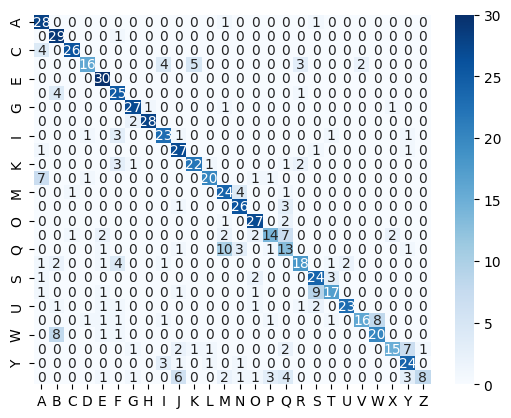

In [ ]:
calcular_metricas("/content/test_propio/IMGS_TEST")